## TREE 모델 속도개선

In [ ]:
# 1. 히스토그램 방식(Histogram-based): 
# 데이터를 구간으로 나누고 각 구간의 빈도를 계산하여 데이터를 간소화하는 방식입니다. 
# 이를 통해 데이터의 분포를 파악하고 모델 학습에 활용할 수 있습니다.

# 2. GOSS(Gradient-based One-Side Sampling): 
# GOSS는 그라디언트 기반의 한쪽 샘플링 방법으로, 중요도가 높은 샘플에 더 많은 비중을 두어 학습을 진행하는 방식입니다. 
# 이를 통해 계산량을 줄이고 학습 속도를 높일 수 있습니다.

# 3. EFB(Exclusive Feature Bundle): 
# EFB는 상호 배타적인 특징 번들을 사용하여 다수의 특징을 하나의 번들로 묶는 방식입니다. 
# 이 방법은 고차원 데이터의 특징 수를 줄여 계산 복잡도를 낮추고 모델 학습 속도를 향상시킵니다.

In [ ]:
# 데이터 분포를 쉽게 파악하고자 할 때: 히스토그램 방식
# 중요한 샘플을 우선적으로 학습하고자 할 때: GOSS
# 차원 축소와 메모리 절약이 필요한 경우: EFB

## 히스토그램 방식 (Histogram-based)

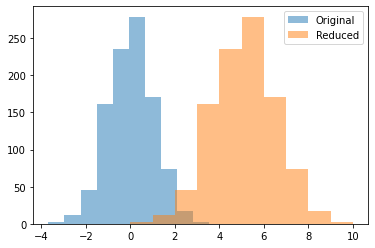

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# 데이터 생성
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# 히스토그램 기반 데이터 간소화 함수
def histogram_based_reduction(X, bins=10):
    """
    데이터를 히스토그램을 사용하여 간소화하는 함수
    X: 입력 데이터 (numpy 배열)
    bins: 히스토그램 구간 수 (기본값: 10)
    """
    X_reduced = np.zeros_like(X)  # 원본 데이터와 동일한 형태의 배열 생성
    for i in range(X.shape[1]):  # 각 특징(feature)에 대해 반복
        # 히스토그램을 사용하여 각 특징의 값을 구간으로 나누고 인덱스로 변환
        X_reduced[:, i] = np.digitize(X[:, i], bins=np.histogram(X[:, i], bins=bins)[1]) - 1
    return X_reduced  # 간소화된 데이터 반환

# 데이터 간소화 적용
X_reduced = histogram_based_reduction(X)

# 결과 시각화 (첫 번째 특징에 대한 히스토그램)
plt.hist(X[:, 0], bins=10, alpha=0.5, label='Original')  # 원본 데이터 히스토그램
plt.hist(X_reduced[:, 0], bins=10, alpha=0.5, label='Reduced')  # 간소화된 데이터 히스토그램
plt.legend(loc='upper right')
plt.show()


## GOSS (Gradient-based One-Side Sampling)

### LIGFTGBM  사례

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.09


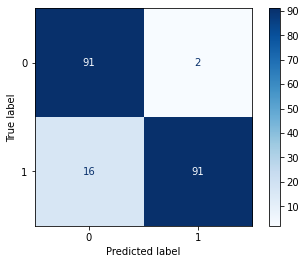

Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        93
           1       0.98      0.85      0.91       107

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.92      0.91      0.91       200



In [12]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# 데이터 생성
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
# 데이터 분할 (훈련 데이터와 테스트 데이터로 나눔)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM 모델 학습 (GOSS 적용)
params = {
    'boosting_type': 'goss',  # GOSS 부스팅 유형 사용
    'objective': 'binary',  # 이진 분류 목적 함수
    'metric': 'binary_error',  # 평가 지표로 이진 오류 사용
    'learning_rate': 0.1,  # 학습률
    'num_leaves': 31,  # 리프 노드 수
    'verbose': -1  # 출력 레벨 설정 (경고 메시지 억제)
}

# LightGBM 데이터셋 생성
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# 조기 종료 콜백 설정
callbacks = [lgb.early_stopping(stopping_rounds=10)]

# 모델 학습
gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, callbacks=callbacks)

# 예측 및 평가
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)  # 예측 수행
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]  # 이진 분류 결과로 변환

# 혼돈 행렬 계산
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 정밀도, 재현율, F1-Score 계산 및 출력
report = classification_report(y_test, y_pred_binary)
print('Accuracy:', accuracy_score(y_test, y_pred_binary))  # 정확도 출력
print(report)  # 정밀도, 재현율, F1-Score 출력


### 조기 종료(Early Stopping) 콜백 설정

In [ ]:
#  머신러닝 모델의 학습 과정에서 과적합을 방지하고 최적의 성능을 가진 모델을 선택하기 위해 사용됩니다.
#         조기 종료는 검증 데이터(validation set)에서 일정 횟수 이상 성능이 향상되지 않으면 학습을 중지하는 방법입니다. 
#     이는 학습 시간이 절약되고 모델이 불필요하게 복잡해지는 것을 막아줍니다.

#### 콜백 설정

In [ ]:
# callbacks = [lgb.early_stopping(stopping_rounds=10)]

# LightGBM에서는 lgb.early_stopping 콜백을 사용하여 조기 종료를 설정합니다. 
# 이를 위해서는 callbacks 매개변수를 lgb.train 함수에 전달해야 합니다

# lgb.early_stopping은 검증 데이터셋의 성능이 stopping_rounds 동안 향상되지 않으면 학습을 중지합니다. 
# 여기서 stopping_rounds=10은 10번의 라운드 동안 성능이 향상되지 않으면 학습을 중지하라는 의미입니다

#### 모델 학습

In [ ]:
# gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, callbacks=callbacks)


# lgb.train 함수에 callbacks 매개변수를 전달하여 조기 종료 콜백을 설정합니다. 
# 이 예제에서는 최대 100번의 부스팅 라운드를 수행하되, 10번 동안 성능이 향상되지 않으면 학습을 중지합니다.

#### 예측 및 평가

In [ ]:
# y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]

# 조기 종료로 학습이 중지된 최적의 부스팅 라운드를 사용하여 예측을 수행합니다.

# 조기 종료는 모델의 일반화 성능을 높이고 학습 시간을 단축하는 데 매우 유용합니다. 
# LightGBM 외에도 다른 머신러닝 라이브러리에서도 유사한 방식으로 조기 종료를 설정할 수 있습니다.

#### 다양한 트리모델

##### 배깅

In [ ]:
# 배깅에서 조기 종료 설정 예제 (Random Forest 사용)
# 배깅의 대표적인 사례인 랜덤 포레스트(Random Forest)는 조기 종료를 직접적으로 지원하지 않지만, 
# 개별 결정 트리에 대해 최대 깊이나 최소 샘플 수 등의 매개변수를 조정하여 과적합을 방지할 수 있다.


# 배깅: 배깅 자체에는 조기 종료 개념이 없지만, 
#     개별 모델의 과적합을 방지하기 위해 최대 깊이(max_depth), 최소 샘플 수(min_samples_split) 등의 매개변수를 조정할 수 있습니다.

##### 부스팅(Boosting)

In [ ]:
# 부스팅은 모델을 순차적으로 학습시키며, 이전 모델의 오차를 보완하는 방식으로 동작합니다. 
# 부스팅 알고리즘에서는 조기 종료를 설정하여 모델의 학습을 조기에 멈추게 할 수 있습니다. 
# 조기 종료는 특히 LightGBM, XGBoost와 같은 부스팅 라이브러리에서 많이 사용됩니다.

### XGBoost 경우

[0]	eval-logloss:0.63617	train-logloss:0.61820
[1]	eval-logloss:0.58841	train-logloss:0.55504
[2]	eval-logloss:0.54545	train-logloss:0.50149
[3]	eval-logloss:0.51126	train-logloss:0.45605
[4]	eval-logloss:0.48396	train-logloss:0.41722
[5]	eval-logloss:0.45753	train-logloss:0.38141
[6]	eval-logloss:0.43340	train-logloss:0.34972
[7]	eval-logloss:0.41468	train-logloss:0.32200
[8]	eval-logloss:0.39883	train-logloss:0.29828
[9]	eval-logloss:0.38409	train-logloss:0.27586
[10]	eval-logloss:0.37122	train-logloss:0.25533
[11]	eval-logloss:0.35965	train-logloss:0.23757
[12]	eval-logloss:0.35234	train-logloss:0.22250
[13]	eval-logloss:0.34582	train-logloss:0.20882
[14]	eval-logloss:0.33982	train-logloss:0.19603
[15]	eval-logloss:0.33556	train-logloss:0.18481
[16]	eval-logloss:0.33163	train-logloss:0.17360
[17]	eval-logloss:0.32620	train-logloss:0.16322
[18]	eval-logloss:0.32437	train-logloss:0.15479
[19]	eval-logloss:0.31896	train-logloss:0.14638
[20]	eval-logloss:0.31405	train-logloss:0.13855
[2

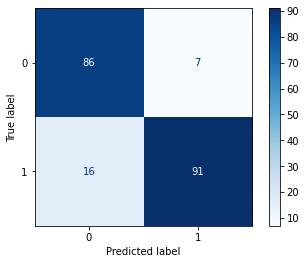

Accuracy: 0.885
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        93
           1       0.93      0.85      0.89       107

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.89      0.89       200



In [16]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 데이터 생성
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
# 데이터 분할 (훈련 데이터와 테스트 데이터로 나눔)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost 모델 학습 파라미터 설정
params = {
    'objective': 'binary:logistic',  # 이진 분류 목적 함수
    'max_depth': 6,  # 트리의 최대 깊이
    'eta': 0.1,  # 학습률
    'eval_metric': 'logloss'  # 평가 지표
}

# 조기 종료를 위한 평가 데이터 설정
evals = [(dtest, 'eval'), (dtrain, 'train')]

# 모델 학습 (조기 종료 설정)
num_round = 100  # 최대 부스팅 라운드 수
early_stopping_rounds = 10  # 조기 종료 라운드 수
bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=early_stopping_rounds)

# 예측 및 평가
y_pred = bst.predict(dtest)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]

# 혼돈 행렬 계산 및 시각화
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 정밀도, 재현율, F1-Score 계산 및 출력
report = classification_report(y_test, y_pred_binary)
print('Accuracy:', accuracy_score(y_test, y_pred_binary))
print(report)


In [ ]:
# 주요 코드 부분 설명

In [ ]:
# 1. XGBoost DMatrix 생성:

# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)
# XGBoost에서 사용할 DMatrix 객체를 생성합니다. 
# DMatrix는 XGBoost에서 데이터를 효율적으로 처리하기 위해 사용하는 데이터 구조입니다.

# 2. 모델 학습 파라미터 설정:

# params = {
#     'objective': 'binary:logistic',  # 이진 분류 목적 함수
#     'max_depth': 6,  # 트리의 최대 깊이
#     'eta': 0.1,  # 학습률
#     'eval_metric': 'logloss'  # 평가 지표
# }

# 모델 학습에 필요한 파라미터를 설정합니다. 
# 여기서는 이진 분류 목적 함수, 트리의 최대 깊이, 학습률, 평가 지표를 설정했습니다.


# 3. 조기 종료를 위한 평가 데이터 설정:

# evals = [(dtest, 'eval'), (dtrain, 'train')]
# 모델 학습 중 성능 평가를 위한 평가 데이터셋을 설정합니다. 
# 검증 데이터셋(dtest)과 훈련 데이터셋(dtrain)을 평가에 사용합니다.


# 4. 모델 학습 및 조기 종료 설정:

# num_round = 100  # 최대 부스팅 라운드 수
# early_stopping_rounds = 10  # 조기 종료 라운드 수
# bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=early_stopping_rounds)
# 최대 100번의 부스팅 라운드를 수행하되, 10번의 라운드 동안 검증 데이터셋의 성능이 향상되지 않으면 학습을 중지합니다.

# 5. 예측 및 평가:

# y_pred = bst.predict(dtest)
# y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]
# 학습된 모델을 사용하여 예측을 수행하고, 이진 분류 결과로 변환합니다.

# 6. 혼돈 행렬 계산 및 시각화:

# cm = confusion_matrix(y_test, y_pred_binary)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap=plt.cm.Blues)
# plt.show()

# 정밀도, 재현율, F1-Score 계산 및 출력:

report = classification_report(y_test, y_pred_binary)
print('Accuracy:', accuracy_score(y_test, y_pred_binary))
print(report)
이 코드는 XGBoost를 사용하여 조기 종료를 설정하고, 모델의 예측 성능을 평가하는 방법을 보여줍니다. 
조기 종료를 통해 불필요한 학습을 방지하고 최적의 모델을 선택할 수 있습니다.

## EFB (Exclusive Feature Bundle)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_error: 0.08


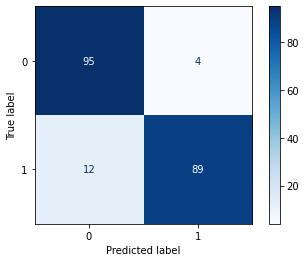

Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        99
           1       0.96      0.88      0.92       101

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



In [13]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 데이터 생성
X, y = make_classification(n_samples=1000, n_features=100, random_state=42)
# 데이터 분할 (훈련 데이터와 테스트 데이터로 나눔)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM 모델 학습 (EFB 적용)
params = {
    'boosting_type': 'gbdt',  # 기본 Gradient Boosting Decision Tree 유형 사용
    'objective': 'binary',  # 이진 분류 목적 함수
    'metric': 'binary_error',  # 평가 지표로 이진 오류 사용
    'learning_rate': 0.1,  # 학습률
    'num_leaves': 31,  # 리프 노드 수
    'verbose': -1,  # 출력 레벨 설정 (경고 메시지 억제)
    'max_bin': 255,  # 최대 빈 수
    'feature_fraction': 0.8,  # 각 부스팅 단계에서 사용할 특징의 비율
    'max_cat_to_onehot': 4,  # 원-핫 인코딩을 적용할 최대 카테고리 수
    'cat_l2': 10,  # 카테고리 특징에 대한 L2 정규화
    'cat_smooth': 10,  # 카테고리 특징에 대한 평활화
    'cat_max_bin': 255  # 카테고리 특징에 대한 최대 빈 수
}

# LightGBM 데이터셋 생성
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# 조기 종료 콜백 설정
callbacks = [lgb.early_stopping(stopping_rounds=10)]

# 모델 학습
gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, callbacks=callbacks)

# 예측 및 평가
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)  # 예측 수행
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]  # 이진 분류 결과로 변환

# 혼돈 행렬 계산
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 정밀도, 재현율, F1-Score 계산 및 출력
report = classification_report(y_test, y_pred_binary)
print('Accuracy:', accuracy_score(y_test, y_pred_binary))  # 정확도 출력
print(report)  # 정밀도, 재현율, F1-Score 출력


In [ ]:
# 특징 선택 및 축소 (Feature Selection and Reduction)

In [ ]:

# 불필요한 특징을 제거하거나, 상관관계가 높은 특징들을 축소하면 학습 속도를 크게 높일 수 있습니다. 
# PCA(Principal Component Analysis) 같은 차원 축소 방법도 유용합니다.

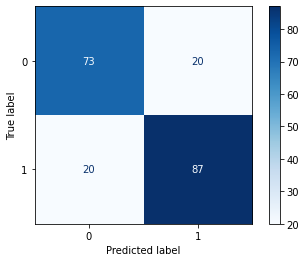

Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        93
           1       0.81      0.81      0.81       107

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200



In [14]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 데이터 생성
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# PCA를 사용한 차원 축소
pca = PCA(n_components=10)  # 원하는 차원 수 설정
X_reduced = pca.fit_transform(X)

# 데이터 분할 (훈련 데이터와 테스트 데이터로 나눔)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# 의사결정나무 모델 학습
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# 예측 및 평가
y_pred = clf.predict(X_test)

# 혼돈 행렬 계산 및 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 정밀도, 재현율, F1-Score 계산 및 출력
report = classification_report(y_test, y_pred)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(report)
